# Building a Robot Judge: Data Science for the Law
## Problem Set 1
Michal Sudwoj

In [1]:
import glob
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.style.use("ggplot")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"]  = ["TeX Gyre Pagella"]

nlp = spacy.load("en_core_web_sm")

1. Use spaCy to process all cases. Split the documents into sentences and tokens. Compute number of sentences, words, and letters for each document. Report histograms for these statistics.

In [2]:
cases = pd.DataFrame({"case" : [], "year" : [], "doc" : []})
filename_regex = r".*/(\d{4})_(.*)\.txt$"
for filename in glob.glob("data/cases/*.txt"):
    with open(filename) as f:
        m = re.match(filename_regex, filename)
        case = m.group(2)
        year = int(m.group(1))
        # Limit to a subset
        if year >= 2011:
            doc = nlp(f.read())
            cases = cases.append({"case" : case, "year" : year, "doc" : doc}, ignore_index = True)

cases_reversed = pd.read_csv("data/case_reversed.csv")
cases = cases.set_index("case").join(cases_reversed.set_index("caseid"))
cases["year"] = cases["year"].apply(int)

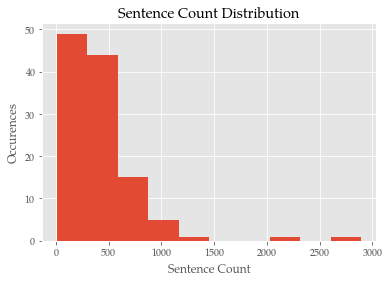

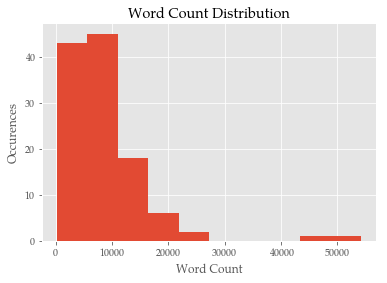

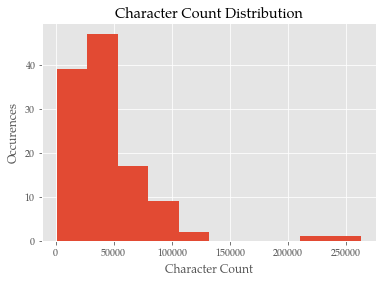

In [3]:
cases["sentence_count"] = cases["doc"].apply(lambda doc: len(list(doc.sents)))
cases["word_count"]     = cases["doc"].apply(lambda doc: len(doc))
cases["char_count"]     = cases["doc"].apply(lambda doc: len(doc.text))

plt.hist(cases["sentence_count"])
plt.title("Sentence Count Distribution")
plt.xlabel("Sentence Count")
plt.ylabel("Occurences")
plt.show()

plt.hist(cases["word_count"])
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Occurences")
plt.show()

plt.hist(cases["char_count"])
plt.title("Character Count Distribution")
plt.xlabel("Character Count")
plt.ylabel("Occurences")
plt.show()

2. Use the spaCy parts of speech (POS) tags to count number of nouns, verbs, and adjectives in each document. Visualize POS frequency by year.

In [4]:
cases["pos"]             = cases["doc"].apply(lambda doc:    Counter([token.pos_ for token in doc]))
cases["token_count"]     = cases["pos"].apply(lambda counts: sum(counts.values()))
cases["noun_count"]      = cases["pos"].apply(lambda counts: counts["NOUN"])
cases["verb_count"]      = cases["pos"].apply(lambda counts: counts["VERB"])
cases["adjective_count"] = cases["pos"].apply(lambda counts: counts["ADJ"])
cases["noun_freq"]       = cases["noun_count"]      / cases["token_count"]
cases["verb_freq"]       = cases["verb_count"]      / cases["token_count"]
cases["adjective_freq"]  = cases["adjective_count"] / cases["token_count"]
cases = cases.drop("pos", axis = "columns")

In [5]:
cases.loc[:, ["year", "noun_count", "verb_count", "adjective_count"]].groupby("year").mean()

,noun_count,verb_count,adjective_count
year,,,
2011,1885.454545,1306.212121,706.696970
2012,1575.170213,1061.659574,574.553191
2013,1281.666667,903.888889,471.833333


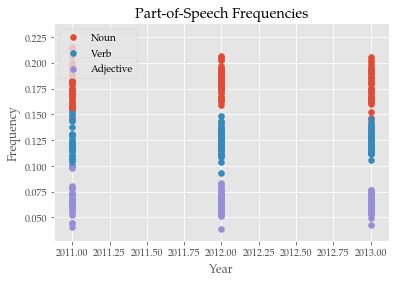

In [6]:
plt.scatter(cases["year"], cases["noun_freq"],      label = "Noun")
plt.scatter(cases["year"], cases["verb_freq"],      label = "Verb")
plt.scatter(cases["year"], cases["adjective_freq"], label = "Adjective")
plt.title("Part-of-Speech Frequencies")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend()
plt.show()

3. Follow the steps in lecture to normalize your corpus (e.g., removing punctuation) and discuss your choices about what information to exclude. Using the normalized tokens, make a feature set of all trigrams that end in a noun. 


In [7]:
def token_filter(doc):
    for token in doc:
        if not token.is_punct and not token.is_space:
            yield token   

def make_ngrams(doc, n):
    tokens = list(token_filter(doc))
    for i in range(len(tokens) - n):
        if tokens[i + n - 1].pos_ == "NOUN":
            yield " ".join([tokens[j].lower_ for j in range(i, i + n)])
        
cases["trigrams"] = cases["doc"].apply(lambda doc: list(make_ngrams(doc, 3)))

In [8]:
cases_trigrams = (cases
    .reset_index()
    .set_index(["case", "year", "case_reversed"])
    ["trigrams"]
    .apply(pd.Series)
    .stack()
    .reset_index()
    .rename(columns = {0 : "trigrams"})
    [["case", "year", "case_reversed", "trigrams"]]
    .assign(n = 1)
    .groupby(["case", "year", "case_reversed", "trigrams"])
    .sum()
)

4. Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun). Standardize the features to variance one while maintaining sparsity. 

In [9]:
cases_features = (cases_trigrams
    .join((cases_trigrams
        .reset_index()
        .set_index(["case", "year", "case_reversed"])
        .groupby(["trigrams"])
        .sum()
        .sort_values("n", ascending = False)
        .query("n > 10")
        .drop("n", axis = "columns")
    ), how = "inner")
    .unstack(level = -1, fill_value = 0)
    .reset_index()
    .drop(["case", "year"], axis = "columns")
)
# ugly hack :S
cases_features.columns = cases_features.columns.get_level_values(1)
cases_features = cases_features.rename(columns = {"" : "case_reversed"})
cases_features

/usr/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


trigrams,case_reversed,'s commerce power,'s due process,'s factual findings,'s good neighbor,'s immigration status,'s prayer practice,'s sales tax,'s third party,105 patent col,...,with the intent,with the law,with the purchase,with the state,with this opinion,withdraw her plea,within the meaning,within the scope,within the state,writ of habeas
0,1,0,0,0,0,0,0,0,0,16,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0


5. Link the dataframe to the outcome reverse. Create a training set and test set. Train a LogisticRegression model with default parameters to predict reversal. Compute accuracy and F1 for the prediction in the training set and in the test set. 

In [10]:
cases_features_train, cases_features_test = train_test_split(cases_features)

lr = LogisticRegression().fit(cases_features_train.drop("case_reversed", axis = "columns"), cases_features_train["case_reversed"])
cases_features_test = cases_features_test.assign(predicted = lr.predict(cases_features_test.drop("case_reversed", axis = "columns")))

In [11]:
accuracy_score(cases_features_test["case_reversed"], cases_features_test["predicted"])

0.6551724137931034

In [12]:
f1_score(cases_features_test["case_reversed"], cases_features_test["predicted"])

0.7916666666666667

6. Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C. Report the best model parameters and score. Report the ROC Curve and AUC.

In [13]:
lr_opt = GridSearchCV(LogisticRegression(), {"penalty" : ("l1", "l2"), "C" : [0.1, 10]}).fit(cases_features_train.drop("case_reversed", axis = "columns"), cases_features_train["case_reversed"])

In [14]:
lr_opt.best_score_

0.6781609195402298

In [15]:
lr_opt.best_params_

{'C': 10, 'penalty': 'l1'}

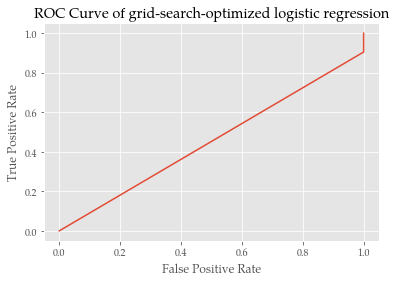

In [16]:
fpr, tpr, thresholds = roc_curve(cases_features_test["case_reversed"], cases_features_test["predicted"])
plt.plot(fpr, tpr)
plt.title("ROC Curve of grid-search-optimized logistic regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [17]:
roc_auc_score(cases_features_test["case_reversed"], cases_features_test["predicted"])

0.4523809523809524

7. Make a new dataframe where each sentence (of each case) is treated as a separate document. Compute vader compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.

In [18]:
sentences = pd.DataFrame(
    cases["doc"]
    .apply(lambda doc: [sentence.text for sentence in doc.sents])
    .apply(pd.Series)
    .stack()
    .reset_index()
    .rename(columns = {0 : "sentences"})
    [["case", "sentences"]]
)

sid = SentimentIntensityAnalyzer()
sentences["scores"] = sentences["sentences"].apply(lambda sentence: sid.polarity_scores(sentence))
sentences["negative"] = sentences["scores"].apply(lambda score: score["neg"])
sentences["neutral"]  = sentences["scores"].apply(lambda score: score["neu"])
sentences["positive"] = sentences["scores"].apply(lambda score: score["pos"])
sentences["compound"] = sentences["scores"].apply(lambda score: score["compound"])
sentences = (sentences
    .drop("scores", axis = "columns")
    .sort_values("compound")
)

In [19]:
sentences.sort_values("compound", ascending = True).iloc[:10]

,case,sentences,negative,neutral,positive,compound
21295,X1IAT92003,COUNT II Count II specifically charged that Ro...,0.183,0.788,0.029,-0.9864
19036,X1FG5UA003,He denied using a higher burden of proof based...,0.359,0.641,0.000,-0.9786
6966,X1I5JB8003,The district court decides whether a claimant ...,0.229,0.760,0.012,-0.9776
15781,X1FUR2G003,"There, the jury convicted Ralph and Louis Wils...",0.382,0.600,0.018,-0.9764
14243,X1FUR2G003,***7] 3143: The prosecution claims that it str...,0.562,0.438,0.000,-0.9741
31138,X1HODI4003,Titlow offered several theories in her defense...,0.324,0.654,0.022,-0.9712
17412,X1J47LU003,Based on the suspected presence of weapons in ...,0.399,0.565,0.036,-0.9702
14054,X1FUR2G003,Six defendants appeal from judgments of convic...,0.435,0.565,0.000,-0.9694
27869,X1Q6MBTN2J82,The two primary forms of prejudice in the lach...,0.295,0.705,0.000,-0.9674
39048,X1HUG6K003,Second-degree murder is an unlawful killing an...,0.507,0.493,0.000,-0.9661


In [20]:
sentences.sort_values("compound", ascending = False).iloc[:10]

,case,sentences,negative,neutral,positive,compound
1907,X1K7T84003,"To the extent that vesting was presumed, it wa...",0.019,0.685,0.296,0.9824
24143,X1I6KT4003,"(1) Subject to sections 1103(c) and (d) , 1342...",0.027,0.803,0.170,0.9702
40302,X1EU59K003,Justice O'Connor observed that including diver...,0.000,0.574,0.426,0.9692
19124,X1FG5UA003,"Under AEDPA, federal courts may grant habeas r...",0.034,0.718,0.248,0.9643
2672,X1GSJV4003,"See, e.g. , Civil Rights Attorney's Fee Awards...",0.000,0.794,0.206,0.9571
2018,X1HB3F4003,"Specifically, the plaintiffs allege that the S...",0.011,0.848,0.141,0.9556
24082,X1K8STM003,"In Levin , the Court discussed three factors t...",0.031,0.700,0.269,0.9545
39212,X1HUG6K003,The retroactive application of Carpenter was a...,0.000,0.713,0.287,0.9538
48133,X1I6VCE003,"In 1956, based on the specific facts of the em...",0.067,0.774,0.160,0.9538
31177,X1HODI4003,That subsection provides as follows: An applic...,0.015,0.815,0.170,0.9536


8. Use TfidfVectorizer to compute tf-idf frequencies for each sentence, and then compute cosine similarities between all sentences. Report example pairs of very similar sentences and very dissimilar sentences. 

In [21]:
sentences_tfidf = TfidfVectorizer(min_df = 0.001, max_df = 0.5, stop_words = "english", dtype = np.float32).fit_transform(sentences["sentences"])
sentences_similarities = cosine_similarity(sentences_tfidf, dense_output = False)

NameError: name 'float32' is not defined

In [ ]:
#sentences_similarities[sentences_similarities != 1]

9. Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster. 

### Extra Assignment
You need to calculate the cosine similarity between each pair of observations in the frequency matrices, $D_1 \in n_1 \times m_1$ and $D_2 \in n_2 \times m_2$. The names of the columns in these matrices correspond to the names of the features in the dictionaries of the datasets. Your task is to obtain the linear transformation that would allow to compute the similarity for $D_1 T_1 = D_1'$ and $D_2 T_2 = D_2'$ such that $D_1'$ and $D_2'$ lie in the same dictionary space of the size $m_3$ and to compute the similarity. 

Write a function in Python: `get_transformation(D1 , D2) -> T1, T2`.
Write a function in Python that uses your function from (1) to compute the cosine similarity between `D1` and  `D2`: `cosine_sim(T1, T2, D1 , D2)` Note: The output must be a matrix of the size $n_1 \times n_2$ corresponding to the cosine similarity between each observation in `D1` and `D2` .

Please, explain each step in your code. 
